In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [3]:
def preprocess_train_data(train_data_path): # include type hints later and 
    # clean up the return from docstring
    """
    Split train data into features and target
    csv file specified in path is read as pandas df.
    The columns are renamed. 
    
    Arguments
    _________
    train_data_path : system path for training csv file
    
    Returns
    _______
    Pandas dataframe
    """
    
    stores_sales = pd.read_csv(train_data_path)

    # rename target column to business for intuition. Increase the business.
    stores_sales.rename(columns={'Item_Outlet_Sales':'business'}, inplace=True)

    # parse target(buisness) and features(situations) for intuition
    situations = stores_sales.drop(columns=['business'])
    business = stores_sales['business']

    return situations, business

In [4]:
def get_cat_feature_names(situations):
    """
    Gives the list of categorical column names

    Returns
    _______
    list of names
    """
    # store column data types as pandas series
    columns_types = situations.dtypes

    # filter the series for object datatype using object string and get index. 
    # Then convert index to array
    return columns_types[columns_types == 'object'].index.values

In [5]:
def get_num_feature_names(situations):
    """
    Gives the list of numerical column names

    Returns
    _______
    list of names
    """
    # store column data types as pandas series
    columns_types = situations.dtypes

    # filter the series for object datatype using object string and get index. 
    # Then convert index to array
    return columns_types[columns_types != 'object'].index.values

In [6]:
def encode_cat_cols(situations, cat_cols_encoder_types):
    """
    Encodes categroical columns in situations.

    2. Stores the encoders in a dict against each column name. The column encoder is 
    retrieved for a col name and fit/trained on that column data in situations. Then, the  
    column is then encoded in situations. (Do I need to store the encoder? 
    Will it be used later on? What about the encoding of future dataset?)

    3. The new encoded columns are added to situations with new names.
    The encoded name to original name dict is maintained. It is returned for future use.
    
    Returns
    _______
    situations df with encoded columns
    enc_col_names_to_col_names_dict
    
    """

    # col encoders dictionary will store the encoders for each colum
    col_encoders_dict = {}

    # enc_col_names_to_col_names_dict will store the encoded column name
    # to original column name mapping 
    enc_col_names_to_col_names_dict = {}

    # Pick up cat column from cat_cols_encoder_types one at a time
    for col, encoder_type in cat_cols_encoder_types.items():
        encoded_col_name = f"{col}_encoded"

        # storing mapping from encoded columns 
        # to original columns
        enc_col_names_to_col_names_dict[encoded_col_name] = col

        # Creating encoder for each column and storing in dict
        if encoder_type == 'label':
            col_encoders_dict[col] = LabelEncoder()
            # fitting the encoders on cat column of situation and
            # encoding the columns in situations
            situations[encoded_col_name] = col_encoders_dict[col].fit_transform(situations[col])
        else:
            col_encoders_dict[col] = OneHotEncoder(sparse_output=False)
            # fitting the encoders on cat column of situation and
            # encoding the columns in situations
            encoded_array = col_encoders_dict[col].fit_transform(situations[[col]])
            # Add the one-hot encoded columns to the DataFrame
            for i, category in enumerate(col_encoders_dict[col].categories_[0]):
                situations[f"{encoded_col_name}_{category}"] = encoded_array[:, i]

    return situations, col_encoders_dict

In [7]:
def get_unique_cat_values_from_situations(situations):
    situations_cat_cols_names = get_cat_feature_names(situations)
    situations_cat_cols_values = {}

    for cat_col in situations_cat_cols_names:
        # get one column of the situation
        # store the unique values in a dict
        situations_cat_cols_values[cat_col] = situations[cat_col].unique()
        # return the dict to visualise it

    return situations_cat_cols_values

In [8]:
def clean_cat_columns(situations):
    """
    standardise the categories within catgeorical columns.
    Removes duplicate categories

    Returns
    _______
    df with categories cleaned
    """
    # replace 'Low Fat' 'low fat' with LF in Item_Fat_Content
    situations.loc[(situations['Item_Fat_Content'] == 'Low Fat')\
                    | (situations['Item_Fat_Content'] == 'low fat'),\
                    'Item_Fat_Content'] = 'LF'
    
    # replace 'Low Fat' 'low fat' with LF in Item_Fat_Content
    situations.loc[situations['Item_Fat_Content'] == 'Regular','Item_Fat_Content'] = 'reg'    

    return situations

## Cleaning

In [9]:
train_data_path = r'/Users/yadav.a.1/Downloads/train_v9rqX0R.csv'
situations, business  = preprocess_train_data(train_data_path=train_data_path)

In [10]:
situations.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
dtype: object

### Clean up categorical columns. 
First See the values

In [11]:
situations_cat_cols_values_dict = get_unique_cat_values_from_situations(situations)
for col in situations_cat_cols_values_dict:
    print("\n", col, "\n", situations_cat_cols_values_dict[col])


 Item_Identifier 
 ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

 Item_Fat_Content 
 ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

 Item_Type 
 ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

 Outlet_Identifier 
 ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

 Outlet_Size 
 ['Medium' nan 'High' 'Small']

 Outlet_Location_Type 
 ['Tier 1' 'Tier 3' 'Tier 2']

 Outlet_Type 
 ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


standardise categoriies to remove duplicates
Item_Fat_Content : combine 'Low Fat' 'low fat' 'LF' and 'Regular''reg'

In [12]:
situations = clean_cat_columns(situations)
print("\n", situations['Item_Fat_Content'].unique())


 ['LF' 'reg']


### Cleaning up numerical columns
'Item_Weight' 'Item_Visibility' 'Item_MRP' 'Outlet_Establishment_Year'

In [13]:
num_cols = get_num_feature_names(situations)
print(num_cols)

['Item_Weight' 'Item_Visibility' 'Item_MRP' 'Outlet_Establishment_Year']


1. boxplot will show us outliers
2. Histogram will show us garbage values
3. print unique values of year

Outlet_Establishment_Year

In [14]:
print(sorted(situations['Outlet_Establishment_Year'].unique()))

[1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009]


<BarContainer object of 9 artists>

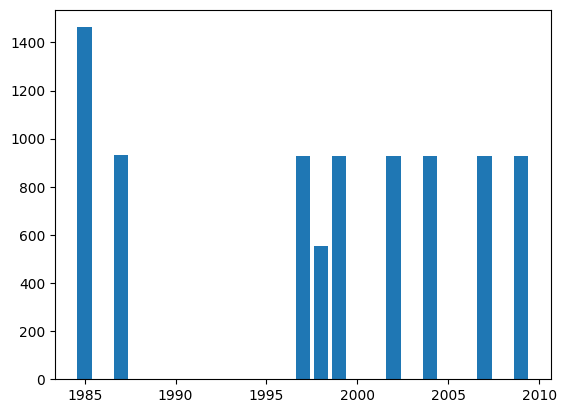

In [15]:
year_value_counts = situations['Outlet_Establishment_Year'].value_counts()
plt.bar(year_value_counts.index, year_value_counts.values)

Item_Weight
histogram

(array([483., 870., 865., 664., 779., 629., 755., 735., 677., 603.]),
 array([ 4.555 ,  6.2345,  7.914 ,  9.5935, 11.273 , 12.9525, 14.632 ,
        16.3115, 17.991 , 19.6705, 21.35  ]),
 <BarContainer object of 10 artists>)

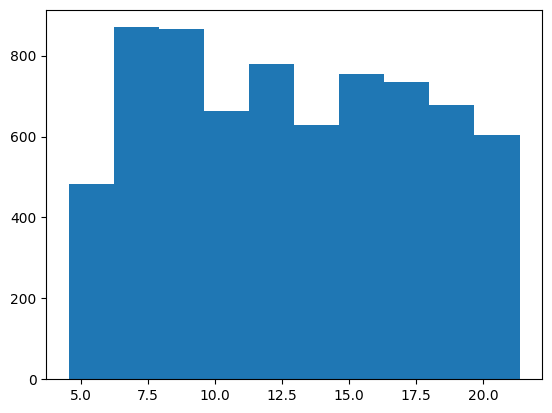

In [16]:
plt.hist(situations['Item_Weight'])

Item_Visibility
1. hist, boxplot

(array([2639., 2329., 1563.,  979.,  593.,  279.,   60.,   35.,   29.,
          17.]),
 array([0.        , 0.03283909, 0.06567819, 0.09851728, 0.13135638,
        0.16419547, 0.19703457, 0.22987366, 0.26271276, 0.29555185,
        0.32839095]),
 <BarContainer object of 10 artists>)

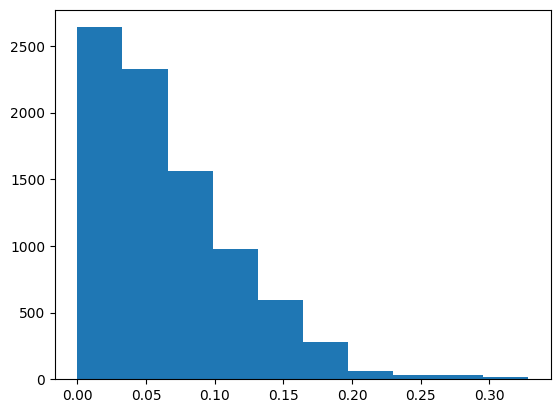

In [17]:
plt.hist(situations['Item_Visibility'])

{'whiskers': [<matplotlib.lines.Line2D at 0x17542c3a0>,
 'caps': [<matplotlib.lines.Line2D at 0x17542c9a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x175371ff0>],
 'medians': [<matplotlib.lines.Line2D at 0x17542cfa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17542d2a0>],
 'means': []}

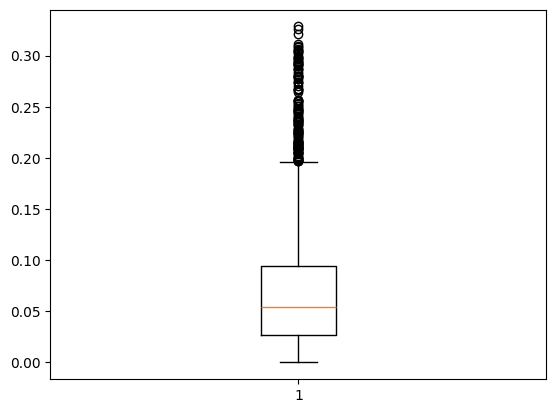

In [18]:
plt.boxplot(situations['Item_Visibility'])

Item_MRP

(array([ 923.,  573., 1053., 1248.,  804., 1098., 1200.,  480.,  557.,
         587.]),
 array([ 31.29   ,  54.84984,  78.40968, 101.96952, 125.52936, 149.0892 ,
        172.64904, 196.20888, 219.76872, 243.32856, 266.8884 ]),
 <BarContainer object of 10 artists>)

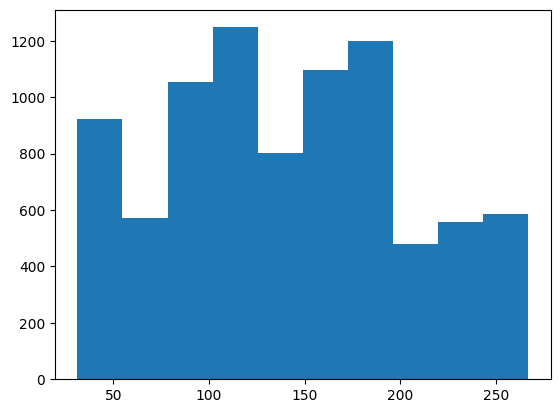

In [19]:
plt.hist(situations['Item_MRP'])

{'whiskers': [<matplotlib.lines.Line2D at 0x175516920>,
 'caps': [<matplotlib.lines.Line2D at 0x175516f20>,
 'boxes': [<matplotlib.lines.Line2D at 0x175516620>],
 'medians': [<matplotlib.lines.Line2D at 0x175517520>],
 'fliers': [<matplotlib.lines.Line2D at 0x175517820>],
 'means': []}

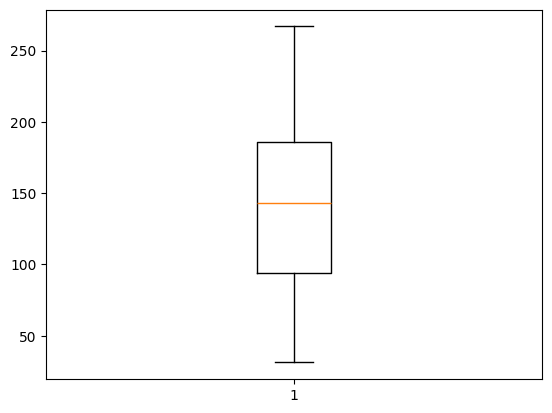

In [20]:
plt.boxplot(situations['Item_MRP'])

## Missing Values

In [21]:
situations.isna().sum() * 100 / len(situations)

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
dtype: float64

Fill missing values in Item_Weight

 1. We'll normalize the numerical columns like Item_Visibility and Item_MRP. Finally, we'll apply k-NN imputation. Ww will also use one hot encoded Item_Identifier_encoded, and Item_Type_encoded and label encoded Item_Fat_Content_encoded to estimate the missing values in Item_Weight, experimenting with different values of k to find the best fit.

 2. Use itme identifier to fill in weight. Yes, that's exactly right. You'll create a dictionary mapping item identifiers to their weights, then use that dictionary to fill in the missing weights based on the item identifier. It's a straightforward and efficient way to handle the missing data in this case.

In [22]:
# create dict with item identifiers as keys and real weights as values
# get item identifers with non missing weights
weights_df = situations[~situations['Item_Weight'].isna()][['Item_Identifier', 'Item_Weight']].drop_duplicates()
weights_dict = weights_df.set_index('Item_Identifier')['Item_Weight'].to_dict()

# create a list of item identifiers with missing weights.
missing_weights_items = situations[situations['Item_Weight'].isna()]['Item_Identifier'].drop_duplicates()

print(len(missing_weights_items), len(weights_dict))

# check if they have weights in the dict
found_items = set(missing_weights_items).intersection(set(weights_dict))
print(len(found_items))

1142 1555
1138


fill the 1138 item weights and just fill the category mean for the reamining 4.
The fillna method will just look up those IDs in the dict that are missing the weights. Then it will map the corrsponign weight from the dict 


In [23]:
def fill_missing_item_weight(situations, weights_dict):
    situations['Item_Weight'].fillna(situations['Item_Identifier'].map(weights_dict), inplace=True)
    situations['Item_Weight'].fillna(situations['Item_Weight'].mean(), inplace=True)

    return situations

In [24]:
situations = fill_missing_item_weight(situations, weights_dict) 
situations.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

Fill missing values in Outlet_Size

In [25]:
# create dict with item identifiers as keys and real weights as values
# get item identifers with non missing weights
weights_df = situations[~situations['Outlet_Size'].isna()][['Outlet_Identifier', 'Outlet_Size']].drop_duplicates()
weights_dict = weights_df.set_index('Outlet_Identifier')['Outlet_Size'].to_dict()

# create a list of item identifiers with missing weights.
missing_weights_items = situations[situations['Outlet_Size'].isna()]['Outlet_Identifier'].drop_duplicates()

print(len(missing_weights_items), len(weights_dict))

# check if they have weights in the dict
found_items = set(missing_weights_items).intersection(set(weights_dict))
print(len(found_items))

3 7
0


Cannot fill outlet size using a map. Unique outlets are missing size. What re thes eoutlet types? What are there years?


That's correct. Outlet_Identifier won't be necessary for k-NN imputation, and Outlet_Establishment_Year should be normalized. We can use standardization or min-max scaling for that.

1. with this kn imputation i want your advice so i'm thinking i'll create a new data set with just the outlet features except the outlet identifier and then I'll normalize or whatever you know scale the establishment here so how is that sounding to get started
2. 

In [26]:
situations.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [27]:
outlets = situations[['Outlet_Identifier', 'Outlet_Size','Outlet_Location_Type', 
            'Outlet_Establishment_Year', 'Outlet_Type']].drop_duplicates()

oulets_missing_size = outlets[outlets['Outlet_Size'].isna()]
oulets_with_size = outlets[~outlets['Outlet_Size'].isna()]

In [28]:
oulets_missing_size

,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Establishment_Year,Outlet_Type
3,OUT010,NaN,Tier 3,1998,Grocery Store
8,OUT045,NaN,Tier 2,2002,Supermarket Type1
9,OUT017,NaN,Tier 2,2007,Supermarket Type1


In [29]:
oulets_with_size

,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Establishment_Year,Outlet_Type
0,OUT049,Medium,Tier 1,1999,Supermarket Type1
1,OUT018,Medium,Tier 3,2009,Supermarket Type2
4,OUT013,High,Tier 3,1987,Supermarket Type1
7,OUT027,Medium,Tier 3,1985,Supermarket Type3
11,OUT046,Small,Tier 1,1997,Supermarket Type1
19,OUT035,Small,Tier 2,2004,Supermarket Type1
23,OUT019,Small,Tier 1,1985,Grocery Store


OUT017 tier 2 outlet of supermarket type that opened in 2007.There is just one oulet OUT035, similar to that. Good thing is its very similar so Ill use this small size to impute. 

OUT045 tier 2 outlet of supermarket type that opened in 2002. Again using OUT035 size Small.

OUT010 is tier 3 grocery in 1998. No similar store. So, I will just medium. 

In [30]:
def fill_missing_outlet_size(situations):    
    situations.loc[situations['Outlet_Identifier'] == 'OUT017', 'Outlet_Size'] = 'Small'
    situations.loc[situations['Outlet_Identifier'] == 'OUT045', 'Outlet_Size'] = 'Small'
    situations.loc[situations['Outlet_Identifier'] == 'OUT010', 'Outlet_Size'] = 'Medium'

    return situations

In [31]:
situations = fill_missing_outlet_size(situations)

In [32]:
situations.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

## Outliers

## Encoding categorical variables

In [33]:
# Define which columns are ordinal vs. nominal
# Identifiers are treated as ordinal here for simplicity, as one-hot encoding them would create too many features.
ordinal_cols = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Item_Identifier']
nominal_cols = ['Item_Type', 'Outlet_Type', 'Outlet_Identifier']

# Create the dictionary to specify encoder types
cat_cols_and_encoder_types = {col: 'label' for col in ordinal_cols}
cat_cols_and_encoder_types.update({col: 'onehot' for col in nominal_cols})

# Display the resulting dictionary
print(cat_cols_and_encoder_types)

{'Item_Fat_Content': 'label', 'Outlet_Size': 'label', 'Outlet_Location_Type': 'label', 'Item_Identifier': 'label', 'Item_Type': 'onehot', 'Outlet_Type': 'onehot', 'Outlet_Identifier': 'onehot'}


In [34]:
# get categorical features of situations
only_situations_cat_cols_before_encoding = get_cat_feature_names(situations)
situations, situations_cat_cols_encoders = encode_cat_cols(
                                              situations, cat_cols_and_encoder_types)
print("Situations cat columns are encoded and added!")

Situations cat columns are encoded and added!


In [35]:
situations

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Outlet_Identifier_encoded_OUT010,Outlet_Identifier_encoded_OUT013,Outlet_Identifier_encoded_OUT017,Outlet_Identifier_encoded_OUT018,Outlet_Identifier_encoded_OUT019,Outlet_Identifier_encoded_OUT027,Outlet_Identifier_encoded_OUT035,Outlet_Identifier_encoded_OUT045,Outlet_Identifier_encoded_OUT046,Outlet_Identifier_encoded_OUT049
0,FDA15,9.300,LF,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,DRC01,5.920,reg,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FDN15,17.500,LF,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,FDX07,19.200,reg,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCD19,8.930,LF,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,LF,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8519,FDS36,8.380,reg,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8520,NCJ29,10.600,LF,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8521,FDN46,7.210,reg,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# # check number of stores and their presence in stores
# items_sell_in_number_of_stores = situations.groupby('Item_Identifier')['Outlet_Identifier'].count()
# print(len(items_sell_in_number_of_stores))
# print(items_sell_in_number_of_stores.describe())

Every item sells in 1-10 stores. Most items sell around 5 number of stores.

column names after encoding

In [37]:
# Check all the columns in situations. It has both encoded and raw columns
print("Situations columns after encoding all the categorical columns has these columns")
print('_'*80)
all_situations_columns_after_encoding = situations.columns.values
print(all_situations_columns_after_encoding)

# Seperate columns that are not in raw cat columns. So, non-cat and encoded cat will be in features
only_situations_features_after_encoding = [col for col in all_situations_columns_after_encoding if col not in only_situations_cat_cols_before_encoding]
print("\n\nSituations column names after removing original unencoded cat columns")
print('_' * 80)
print(only_situations_features_after_encoding, "\n")

# Check number of columns before and after removing
print(f"\nTotal number of columns names after encoding is {len(all_situations_columns_after_encoding)}")
print("\nNumber of original unencoded categorical columns names is", len(only_situations_cat_cols_before_encoding))
print(f"\nNumber of column names after removing unecoded columns {len(only_situations_features_after_encoding)}")

Situations columns after encoding all the categorical columns has these columns
________________________________________________________________________________
['Item_Identifier' 'Item_Weight' 'Item_Fat_Content' 'Item_Visibility'
 'Item_Type' 'Item_MRP' 'Outlet_Identifier' 'Outlet_Establishment_Year'
 'Outlet_Size' 'Outlet_Location_Type' 'Outlet_Type'
 'Item_Fat_Content_encoded' 'Outlet_Size_encoded'
 'Outlet_Location_Type_encoded' 'Item_Identifier_encoded'
 'Item_Type_encoded_Baking Goods' 'Item_Type_encoded_Breads'
 'Item_Type_encoded_Breakfast' 'Item_Type_encoded_Canned'
 'Item_Type_encoded_Dairy' 'Item_Type_encoded_Frozen Foods'
 'Item_Type_encoded_Fruits and Vegetables' 'Item_Type_encoded_Hard Drinks'
 'Item_Type_encoded_Health and Hygiene' 'Item_Type_encoded_Household'
 'Item_Type_encoded_Meat' 'Item_Type_encoded_Others'
 'Item_Type_encoded_Seafood' 'Item_Type_encoded_Snack Foods'
 'Item_Type_encoded_Soft Drinks' 'Item_Type_encoded_Starchy Foods'
 'Outlet_Type_encoded_Grocery St

## Modelling

In [38]:
situations_all_columns = situations.copy()
situations = situations[only_situations_features_after_encoding]

In [ ]:
# Fit the model and see train error
model = LGBMRegressor()
trained_model = model.fit(situations, business)
predictions = trained_model.predict(situations)
print("LightGBM RMSE:", np.sqrt(mean_squared_error(business, predictions)))
print("LightGBM MAPE:", mean_absolute_percentage_error(business, predictions))

# Experiment with Random Forest and XGBoost models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Random Forest Model
model_rf = RandomForestRegressor(random_state=42)
trained_model_rf = model_rf.fit(situations, business)
predictions_rf = trained_model_rf.predict(situations)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(business, predictions_rf)))
print("Random Forest MAPE:", mean_absolute_percentage_error(business, predictions_rf))

# XGBoost Model
model_xgb = XGBRegressor(random_state=42)
trained_model_xgb = model_xgb.fit(situations, business)
predictions_xgb = trained_model_xgb.predict(situations)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(business, predictions_xgb)))
print("XGBoost MAPE:", mean_absolute_percentage_error(business, predictions_xgb))

LightGBM RMSE: 900.4257364265759
LightGBM MAPE: 0.5038499995710761
Random Forest RMSE: 421.3046741102831
Random Forest MAPE: 0.21098223390614615
XGBoost RMSE: 662.3930941506362
XGBoost MAPE: 0.39078428947546706


In [44]:
import warnings

warnings.filterwarnings('ignore')

In [45]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(situations, business)

# Get the best RMSE
print("Best RMSE:", np.sqrt(-grid_search.best_score_))


/opt/homebrew/Caskroom/miniforge/base/envs/cpfr-factory/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cpfr-factory/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cpfr-factory/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep th

In [47]:
print("Random Forest Best RMSE:", np.sqrt(-grid_search.best_score_))

Random Forest Best RMSE: 1098.0541548956442


In [48]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Initialize the XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Perform Grid Search with 3-fold cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# Fit the grid search to the data
grid_search_xgb.fit(situations, business)

# Get the best RMSE
print("XGBoost Best RMSE:", np.sqrt(-grid_search_xgb.best_score_))

XGBoost Best RMSE: 1080.3824741120022


In [49]:
print("XGBoost Best RMSE:", np.sqrt(-grid_search_xgb.best_score_))

XGBoost Best RMSE: 1080.3824741120022


In [50]:
# Define the parameter grid for LightGBM
param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the LightGBM Regressor
lgb = LGBMRegressor(random_state=42)

# Perform Grid Search with 3-fold cross-validation
grid_search_lgb = GridSearchCV(estimator=lgb, param_grid=param_grid_lgb, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# Fit the grid search to the data
grid_search_lgb.fit(situations, business)

# Get the best RMSE
print("LightGBM Best RMSE:", np.sqrt(-grid_search_lgb.best_score_))

LightGBM Best RMSE: 1095.2107532265873


In [51]:
print("LightGBM Best RMSE:", np.sqrt(-grid_search_lgb.best_score_))

LightGBM Best RMSE: 1095.2107532265873


In [52]:
trained_model = trained_model_xgb

## Prediction

1. Load test data
2. clean categorical columns
3. encode cat columns
4. Mask out original cat_columns from dataset
5. generate prediction
6. Just keep desired columns and prediction column

load test data

In [53]:
# load test data
stores_assortments = pd.read_csv(r'/Users/yadav.a.1/Downloads/test_AbJTz2l.csv')
stores_assortments[1:3]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1,FDW14,8.3,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.6,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store


clean categorical columns

In [54]:
# clean categorical columns
stores_assortments = clean_cat_columns(stores_assortments)
print("columns cleaned!\n", stores_assortments['Item_Fat_Content'].unique())

columns cleaned!
 ['LF' 'reg']


Fill missing values

In [55]:
stores_assortments.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [56]:
outlets = stores_assortments[['Outlet_Identifier', 'Outlet_Size','Outlet_Location_Type', 
            'Outlet_Establishment_Year', 'Outlet_Type']].drop_duplicates()

oulets_missing_size = outlets[outlets['Outlet_Size'].isna()]
oulets_with_size = outlets[~outlets['Outlet_Size'].isna()]

In [57]:
oulets_missing_size

,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Establishment_Year,Outlet_Type
1,OUT017,NaN,Tier 2,2007,Supermarket Type1
2,OUT010,NaN,Tier 3,1998,Grocery Store
8,OUT045,NaN,Tier 2,2002,Supermarket Type1


same columsn as train. just use teh function

In [58]:
stores_assortments = fill_missing_item_weight(stores_assortments, weights_dict)
stores_assortments = fill_missing_outlet_size(stores_assortments)

encode categorical columns

In [59]:
situations_cat_cols_encoders

{'Item_Fat_Content': LabelEncoder(),
 'Outlet_Size': LabelEncoder(),
 'Outlet_Location_Type': LabelEncoder(),
 'Item_Identifier': LabelEncoder(),
 'Item_Type': OneHotEncoder(sparse_output=False),
 'Outlet_Type': OneHotEncoder(sparse_output=False),
 'Outlet_Identifier': OneHotEncoder(sparse_output=False)}

In [60]:
# get categorical cols of stores_assortments
stores_assortments_cat_cols_names = get_cat_feature_names(stores_assortments)

# got to each cat col of stores_assortments
for col in stores_assortments_cat_cols_names:
    print("\n", col)

    if col in situations_cat_cols_encoders:
        encoder = situations_cat_cols_encoders[col]
        # Now, proceed with transformation
        if cat_cols_and_encoder_types[col] == 'label':
            enc_col = f"{col}_encoded"
            stores_assortments[enc_col] = encoder.transform(stores_assortments[col])
            print(f"Label encoded {col}")
        else: # OneHotEncoder
            enc_col = f"{col}_encoded"
            encoded_array = encoder.transform(stores_assortments[[col]])
            for i, category in enumerate(encoder.categories_[0]):
                stores_assortments[f"{enc_col}_{category}"] = encoded_array[:, i]
            print(f"OneHot encoded {col}")
    else:
        print(f"Column '{col}' was not in the training data encoders dictionary.")



 Item_Identifier
Label encoded Item_Identifier

 Item_Fat_Content
Label encoded Item_Fat_Content

 Item_Type
OneHot encoded Item_Type

 Outlet_Identifier
OneHot encoded Outlet_Identifier

 Outlet_Size
Label encoded Outlet_Size

 Outlet_Location_Type
Label encoded Outlet_Location_Type

 Outlet_Type
OneHot encoded Outlet_Type


Mask out original cat_columns from dataset

In [61]:
# stores_assortments has all columns. 
# stores_assortments_cat_cols_names has original cat column names
# get all column names now
print("All columns now")
print('_'*80)
all_columns_after_encoding = stores_assortments.columns.values
print(all_columns_after_encoding)

# remove column names that are in stores_assortments_cat_cols_names and get new column names
# Seperate columns that are not in raw cat columns. So, non-cat and encoded cat will be in features
only_features = [col for col in all_columns_after_encoding if col not in stores_assortments_cat_cols_names]
print("\n\nonly features columns")
print('_' * 80)
print(only_features, "\n")
# mask is ready


All columns now
________________________________________________________________________________
['Item_Identifier' 'Item_Weight' 'Item_Fat_Content' 'Item_Visibility'
 'Item_Type' 'Item_MRP' 'Outlet_Identifier' 'Outlet_Establishment_Year'
 'Outlet_Size' 'Outlet_Location_Type' 'Outlet_Type'
 'Item_Identifier_encoded' 'Item_Fat_Content_encoded'
 'Item_Type_encoded_Baking Goods' 'Item_Type_encoded_Breads'
 'Item_Type_encoded_Breakfast' 'Item_Type_encoded_Canned'
 'Item_Type_encoded_Dairy' 'Item_Type_encoded_Frozen Foods'
 'Item_Type_encoded_Fruits and Vegetables' 'Item_Type_encoded_Hard Drinks'
 'Item_Type_encoded_Health and Hygiene' 'Item_Type_encoded_Household'
 'Item_Type_encoded_Meat' 'Item_Type_encoded_Others'
 'Item_Type_encoded_Seafood' 'Item_Type_encoded_Snack Foods'
 'Item_Type_encoded_Soft Drinks' 'Item_Type_encoded_Starchy Foods'
 'Outlet_Identifier_encoded_OUT010' 'Outlet_Identifier_encoded_OUT013'
 'Outlet_Identifier_encoded_OUT017' 'Outlet_Identifier_encoded_OUT018'
 'Outlet

In [62]:
all_columns_after_encoding = stores_assortments.columns.values
# Seperate columns that are not in raw cat columns. So, non-cat and encoded cat will be in features
only_features = [col for col in all_columns_after_encoding if col not in stores_assortments_cat_cols_names]

# mask is ready

# generate prediction
# In your "generate prediction" section
train_features_columns = situations.columns.tolist() # The columns from your final training df
test_features_for_prediction = stores_assortments[train_features_columns]

In [63]:
# Now predict using the perfectly aligned dataframe
stores_assortments['Item_Outlet_Sales'] = trained_model.predict(test_features_for_prediction)
stores_assortments.loc[stores_assortments['Item_Outlet_Sales'] < 0, 'Item_Outlet_Sales'] = 0

## Submissions

Just keep desiredt columns

In [65]:
# use desired features list
final_cols = ['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']
stores_assortments[final_cols].to_csv(r'/Users/yadav.a.1/Downloads/onehot_and_imputation_reorder_xgboost.csv', index=False)